# Detecting Cyberbullying in Tweets
***

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from time import time

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.externals import joblib
import joblib

from tensorflow.keras.preprocessing.text import Tokenizer

### Loading and Analyzing the data
***

In [2]:
df_scraped = pd.read_csv('data/labeled_tweets.csv')
df_public = pd.read_csv('data/public_data_labeled.csv')

In [3]:
df_scraped.drop_duplicates(inplace = True)
df_scraped.drop('id', axis = 'columns', inplace = True)

df_public.drop_duplicates(inplace = True)

In [4]:
df_scraped.head(2)

,label,full_text
0,Offensive,So Drasko just said he was impressed the girls...
2,Offensive,Drasko they didn't cook half a bird you idiot ...


In [5]:
df_public.head(2)

,label,full_text
0,Non-offensive,!!! RT @mayasolovely: As a woman you shouldn't...
1,Offensive,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...


In [6]:
df = pd.concat([df_scraped, df_public])

In [7]:
df.to_csv('tweets.csv')

In [9]:
df.shape

(35787, 2)

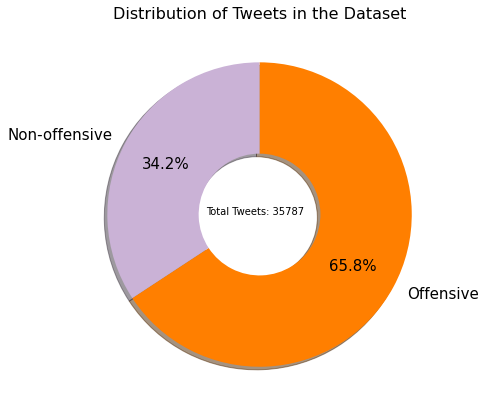

In [10]:
plt.figure(figsize = (7,7))
sorted_counts = df['label'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
        colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.35, y = 0, s = 'Total Tweets: {}'.format(df.shape[0]))
plt.title('Distribution of Tweets in the Dataset', fontsize = 16);

In [11]:
df['label'] = df.label.map({'Offensive': 1, 'Non-offensive': 0})

### Implementing a training and predicting Pipeline
***

Separate training and testing data:

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df['full_text'], 
                                                    df['label'], 
                                                    random_state=42)

print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 35787
Number of rows in the training set: 26840
Number of rows in the test set: 8947


In [32]:
X_test.dtype

dtype('O')

Vectorize the data:

In [13]:
# Instantiate the CountVectorizer method
count_vector = CountVectorizer(stop_words = 'english', lowercase = True)

# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(X_train)

# Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
testing_data = count_vector.transform(X_test)

In [46]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['full_text'])
import pickle
# saving the tokenizer for predict function.
pickle.dump(tokenizer, open('tokenizer1.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences(df['full_text'])[0]
sequence_data[:10]

[37, 846, 33, 143, 74, 47, 4434, 2, 118, 951]

Implement Pipeline:

In [14]:
def pipeline(learner_list, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    # Get length of Training Data:
    size = len(y_train)
    
    results = {}
    final_results = []
    
    for learner in learner_list:
        
        # Store the learner name:
        results['Algorithm'] = learner.__class__.__name__

        # Fit the learner:
        start = time() # Get start time
        print("Training {}".format(learner.__class__.__name__))
        learner = learner.fit(X_train, y_train)
        end = time() # Get end time

        # Store the training time
        results['Training Time'] = end - start

        start = time() # Get start time
        predictions_test = learner.predict(X_test)
        predictions_train = learner.predict(X_train)
        end = time() # Get end time

        # Store the prediction time
        results['Prediction Time'] = end - start

        # Compute the Accuracy on Test Set
        results['Accuracy: Test'] = accuracy_score(y_test, predictions_test)

        # Compute the Accuracy on Training Set
        results['Accuracy: Train'] = accuracy_score(y_train, predictions_train)

        # Compute the F1 Score on Test Set
        results['F1 Score: Test'] = f1_score(y_test, predictions_test)

        # Compute the F1 Score on Training Set
        results['F1 Score: Train'] = f1_score(y_train, predictions_train)

        # Compute the Precision on Test Set
        results['Precision: Test'] = precision_score(y_test, predictions_test)

        # Compute the Precision on Training Set
        results['Precision: Train'] = precision_score(y_train, predictions_train)

        # Compute the Recall on Test Set
        results['Recall: Test'] = recall_score(y_test, predictions_test)

        # Compute the Recall on Training Set
        results['Recall: Train'] = recall_score(y_train, predictions_train)

        # Success
        print("Training {} finished in {:.2f} sec".format(learner.__class__.__name__, results['Training Time']))
        print('----------------------------------------------------')
        
        final_results.append(results.copy())
    # Return a dataframe of the results
    return final_results

Put Algorithms in Pipeline:

In [15]:
# make a list of models
models = [MultinomialNB(), DecisionTreeClassifier(), LinearSVC(), AdaBoostClassifier(), 
          RandomForestClassifier(), BaggingClassifier(),
         LogisticRegression(), SGDClassifier(), KNeighborsClassifier()]

In [16]:
re = pipeline(models, training_data, y_train, testing_data, y_test)
results = pd.DataFrame(re)
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

Training MultinomialNB
Training MultinomialNB finished in 0.01 sec
----------------------------------------------------
Training DecisionTreeClassifier
Training DecisionTreeClassifier finished in 3.33 sec
----------------------------------------------------
Training LinearSVC
Training LinearSVC finished in 0.57 sec
----------------------------------------------------
Training AdaBoostClassifier
Training AdaBoostClassifier finished in 1.01 sec
----------------------------------------------------
Training RandomForestClassifier
Training RandomForestClassifier finished in 35.15 sec
----------------------------------------------------
Training BaggingClassifier
Training BaggingClassifier finished in 22.11 sec
----------------------------------------------------
Training LogisticRegression


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training LogisticRegression finished in 0.74 sec
----------------------------------------------------
Training SGDClassifier
Training SGDClassifier finished in 0.06 sec
----------------------------------------------------
Training KNeighborsClassifier
Training KNeighborsClassifier finished in 0.00 sec
----------------------------------------------------


In [17]:
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

results.sort_values(by = 'F1 Score: Test', inplace = True, ascending = False)

### Analyze the results of the Pipeline
***

In [18]:
results.reset_index(drop = True)

,Algorithm,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
0,SGDClassifier,0.928244,0.962721,0.926701,0.944367,0.001132,0.982489,0.992433,0.980851,0.986608,0.056035
1,BaggingClassifier,0.928244,0.965683,0.923639,0.944193,0.185065,0.988823,0.996907,0.986063,0.991455,22.114846
2,LogisticRegression,0.926344,0.964089,0.922279,0.942721,0.002784,0.978726,0.990241,0.977282,0.983719,0.738675
3,DecisionTreeClassifier,0.925115,0.955738,0.929082,0.942221,0.020284,0.998845,0.999943,0.998300,0.999121,3.330662
4,RandomForestClassifier,0.917738,0.947616,0.926020,0.936694,2.531160,0.998808,0.999490,0.998697,0.999093,35.154663
5,LinearSVC,0.916732,0.946599,0.925510,0.935936,0.001700,0.997019,0.998298,0.997167,0.997733,0.568627
6,AdaBoostClassifier,0.907567,0.972508,0.884354,0.926338,0.208422,0.909650,0.971744,0.888448,0.928231,1.013245
7,MultinomialNB,0.893372,0.901663,0.940306,0.920579,0.004760,0.944560,0.956763,0.959039,0.957900,0.011356
8,KNeighborsClassifier,0.857606,0.895161,0.887245,0.891186,22.836272,0.897727,0.927596,0.915982,0.921753,0.001966


In [19]:
results.describe().loc[['min', 'max'], :]

,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
min,0.857606,0.895161,0.884354,0.891186,0.001132,0.897727,0.927596,0.888448,0.921753,0.001966
max,0.928244,0.972508,0.940306,0.944367,22.836272,0.998845,0.999943,0.998697,0.999121,35.154663


In [20]:
# store the best metric scores
best_acc = results[results['Accuracy: Test'] == results['Accuracy: Test'].max()]
best_f1 = results[results['F1 Score: Test'] == results['F1 Score: Test'].max()]
best_precision = results[results['Precision: Test'] == results['Precision: Test'].max()]
best_recall = results[results['Recall: Test'] == results['Recall: Test'].max()]

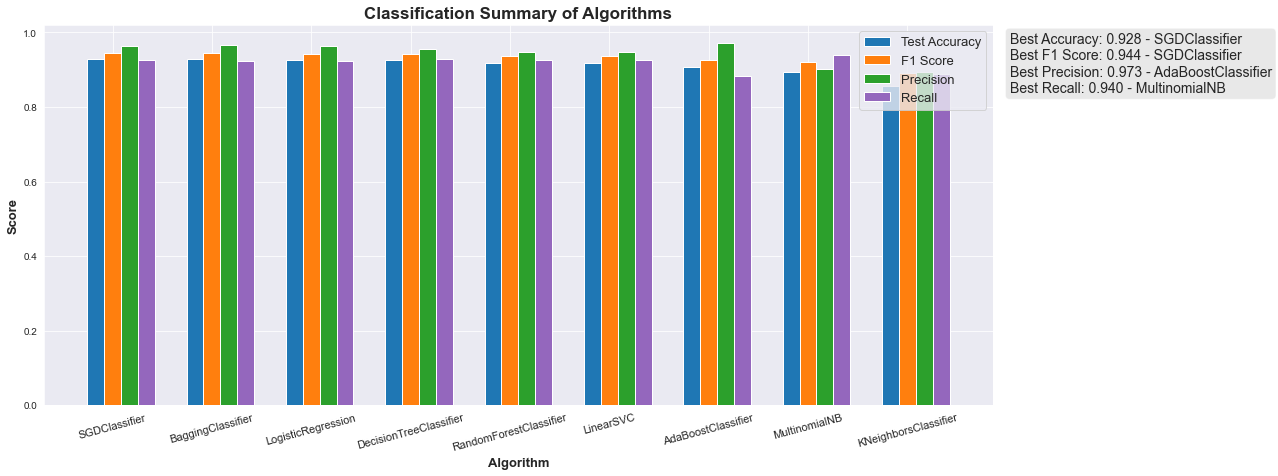

In [21]:
sns.set_style('darkgrid')
plt.figure(figsize = (17, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy: Test']
bars2 = results['F1 Score: Test']
bars3 = results['Precision: Test']
bars4 = results['Recall: Test']

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

 
# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='F1 Score')
plt.bar(r3, bars3, color= pal[2], width=barWidth, edgecolor='white', label='Precision')
plt.bar(r4, bars4, color= pal[4], width=barWidth, edgecolor='white', label='Recall')

 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy: Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score: Test'].values[0], best_f1['Algorithm'].values[0]),
                   'Best Precision: {:.3f} - {}'.format(best_precision['Precision: Test'].values[0], best_precision['Algorithm'].values[0]), 
                    'Best Recall: {:.3f} - {}'.format(best_recall['Recall: Test'].values[0], best_recall['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9.2, 1, textstr, fontsize=14,
        verticalalignment='top', bbox=props)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);

In [22]:
# store the best/worst performance time
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

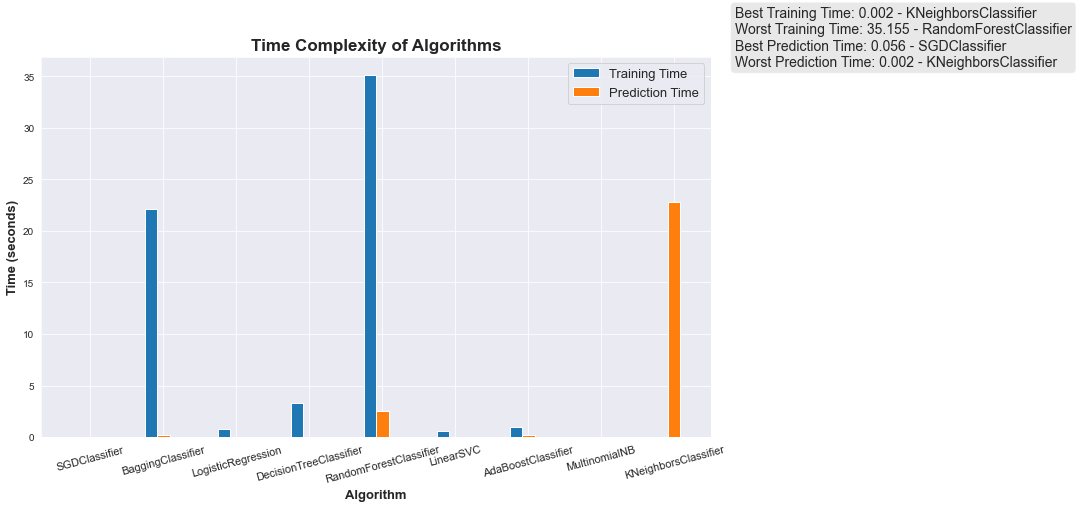

In [23]:
plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))

props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9, 36, textstr, fontsize=14,  bbox=props)

plt.title('Time Complexity of Algorithms', fontweight = 'bold', fontsize = 17);

> The Algorithms Bagging, SGD, Logistic Regression and Decision Tree and Random Forest and LinearSVC have more or less similar performance. We will tune the hyperparameters of these algorithms. However, the training time for Bagging is very high as compared to the others. Hence we drop it. 

### Tuning Hyperparameters
***

In [24]:
def param_tuning(clf, param_dict, X_train, y_train, X_test, y_test):
    
    # make scorer object
    scorer = make_scorer(f1_score)

    # perform Grid Search for Parameters
    grid_obj = GridSearchCV(estimator = clf,
                           param_grid = param_dict,
                           scoring = scorer,
                           cv = 5)

    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
    best_clf = grid_fit.best_estimator_

    # Make predictions using the unoptimized and model
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test)
    
    # Report the before-and-afterscores
    print(clf.__class__.__name__)
    print("\nOptimized Model\n------")
    print("Best Parameters: {}".format(grid_fit.best_params_))
    print("Accuracy: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("F1-score: {:.4f}".format(f1_score(y_test, best_predictions)))
    print("Precision: {:.4f}".format(precision_score(y_test, best_predictions)))
    print("Recall: {:.4f}".format(recall_score(y_test, best_predictions)))

Stochastic Gradient Classifier:

In [25]:
# Dict for parameters
param_grid = {
    'alpha' : [0.095, 0.0002, 0.0003],
    'max_iter' : [2500, 3000, 4000]
}

clf_sgd = SGDClassifier()

param_tuning(clf_sgd, param_grid, training_data, y_train, testing_data, y_test)

SGDClassifier

Optimized Model
------
Best Parameters: {'alpha': 0.0002, 'max_iter': 3000}
Accuracy: 0.9270
F1-score: 0.9431
Precision: 0.9669
Recall: 0.9204


Logistic Regression Classifier:

In [26]:
# Dict for parameters
param_grid = {
    'C': [1, 1.2, 1.3, 1.4]
}

clf_lr = LogisticRegression()

param_tuning(clf_lr, param_grid, training_data, y_train, testing_data, y_test)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#

LogisticRegression

Optimized Model
------
Best Parameters: {'C': 1.2}
Accuracy: 0.9269
F1-score: 0.9432
Precision: 0.9638
Recall: 0.9235


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Decision Tree Classifier:

In [27]:
param_grid = {
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 5, 8]
}

clf_dt = DecisionTreeClassifier()

param_tuning(clf_dt, param_grid, training_data, y_train, testing_data, y_test)

DecisionTreeClassifier

Optimized Model
------
Best Parameters: {'min_samples_leaf': 1, 'min_samples_split': 8}
Accuracy: 0.9232
F1-score: 0.9409
Precision: 0.9518
Recall: 0.9303


Random Forest Classifier:

In [28]:
param_grid = {
    'n_estimators': [50,150],
    'min_samples_leaf': [1, 5],
    'min_samples_split': [2, 5]
}

clf_rf = RandomForestClassifier()

param_tuning(clf_rf, param_grid, training_data, y_train, testing_data, y_test)

RandomForestClassifier

Optimized Model
------
Best Parameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy: 0.9163
F1-score: 0.9356
Precision: 0.9466
Recall: 0.9248


Linear SVC:

In [29]:
param_grid = {
    'C': [0.25, 0.5, 0.75, 1, 1.2]
}

clf_linsvc = LinearSVC()

param_tuning(clf_linsvc, param_grid, training_data, y_train, testing_data, y_test)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC

Optimized Model
------
Best Parameters: {'C': 0.25}
Accuracy: 0.9257
F1-score: 0.9425
Precision: 0.9591
Recall: 0.9264


### Conclusion:
***
We found Stochastic Gradient to be the best suited model for our data. We achieved the following performance parameters:
-	Accuracy: 92.81 %
-	Precision: 96.97 %
-	Recall: 91.94 %
-	F1-Score: 94.39 %

Save the model:

In [30]:
filename = 'cb_sgd_final.sav'
joblib.dump(clf_sgd, filename)

['cb_sgd_final.sav']

In [33]:
testing_data

<8947x38790 sparse matrix of type '<class 'numpy.int64'>'
	with 66471 stored elements in Compressed Sparse Row format>

In [37]:
data = ["You are full of drama"]
count_vectorizer = CountVectorizer(stop_words = 'english', lowercase = True)
data = count_vectorizer.fit_transform(data)

# Check if your vocabulary is being built perfectly
print(count_vectorizer.vocabulary_)

{'drama': 0}


In [38]:
data

<1x1 sparse matrix of type '<class 'numpy.int64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [42]:
t = [["You are full of drama"], ["Non sense"]]
predictions = clf_sgd.predict(t)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


ValueError: Unable to convert array of bytes/strings into decimal numbers with dtype='numeric'